In [1]:
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt

sys.path.append("..")
from src.nce.binary import NceBinaryCrit
from src.nce.cnce import CondNceCrit

from src.noise_distr.normal import MultivariateNormal
from src.noise_distr.conditional_normal import ConditionalMultivariateNormal

from src.models.ring_model.ring_model import RingModel, RingModelNCE, unnorm_ring_model_log_pdf
from src.data.ring_model_dataset import RingModelDataset

from src.training.model_training import train_model
from src.training.training_utils import PrecisionErrorMetric, no_change_stopping_condition

## EXPERIMENT HELP FUNCTIONS

In [2]:
# Noise distribution parameters, NCE

# Adapted from https://github.com/ciwanceylan/CNCE-matlab/blob/master/matlab/synthetic_data/bin/estimation/noise/continous/gNCEnoise.m
def get_nce_noise_distr_par(y):
    mu = torch.mean(y, dim=0)
    cov = torch.cov(torch.transpose(y, 0, 1))
    
    return mu, cov

In [3]:
# Noise distribution parameters, CNCE
# Adapted from https://github.com/ciwanceylan/CNCE-matlab/blob/master/matlab/synthetic_data/bin/estimation/noise/continous/gNoise.m

def get_cnce_epsilon_base(y):
    return torch.std(y, dim=-1).mean()

def get_cnce_covariance_matrix(epsilon_factor, epsilon_base, num_dims):
    return torch.eye(num_dims) * (epsilon_factor * epsilon_base)**2


# Adapted from https://github.com/ciwanceylan/CNCE-matlab/blob/master/matlab/synthetic_data/bin/estimation/noise/continous/gEpsilonBaseFun.m
def get_cnce_noise_distr_par(y, neg_sample_size, mu, log_precision):
    epsilon_factor = get_cnce_epsilon_factor(y, neg_sample_size, mu, log_precision)
    epsilon_base = get_cnce_epsilon_base(y)
    return get_cnce_covariance_matrix(epsilon_factor, epsilon_base, y.size(-1))


def evaluate_cnce_loss(epsilon_factor, neg_sample_size, p_m):
    
    epsilon_base = get_cnce_epsilon_base(y)
    cov_noise = get_cnce_covariance_matrix(epsilon_factor, epsilon_base, y.size(-1))
    
    p_n = ConditionalMultivariateNormal(cov=cov_noise)
    criterion = CondNceCrit(p_m, p_n)
    y_samples = criterion.sample_noise(neg_sample_size * y.size(0), y)
    
    return criterion.crit(y, y_samples)


def get_cnce_epsilon_factor(y, neg_sample_size, mu, log_precision, thrs_lower=0.05, thrs_upper=0.5, inc_rate=0.2, 
                            dec_rate=0.5, max_iter=500, eps_hard_cap=1000):
    
    loss_zero = np.log(2) # Loss as epsilon -> 0 
    loss_inf = 0  # Loss as epsilon -> inf
    thrs_upper = thrs_upper * loss_zero  
    
    num_dims = y.size(-1)
    p_m = RingModel(mu=mu, log_precision=log_precision)  
    
    epsilon_factor = 0.5  # Start value 

    # Calculate initial loss
    loss = evaluate_cnce_loss(epsilon_factor, neg_sample_size, p_m)

    # Iterate until conditions are met 
    k = 1;
    while (k < max_iter) and (abs(1 - (loss/loss_zero)) < thrs_lower or loss < thrs_upper ) and (epsilon_factor < eps_hard_cap):

        if abs(1 - (loss/loss_zero)) < thrs_lower: 
            epsilon_factor = (1 + inc_rate) * epsilon_factor
        elif loss < thrs_upper:
            epsilon_factor = (1 - dec_rate) * epsilon_factor
   
        loss = evaluate_cnce_loss(epsilon_factor, neg_sample_size, p_m)

        k = k + 1
    
    return epsilon_factor


In [4]:
# Generation of true parameters, parameter initialisation

# Adapted from https://github.com/ciwanceylan/CNCE-matlab/blob/master/matlab/synthetic_data/bin/data_generation/generate_parameters.m
def generate_true_params(mu_min=5, mu_max=10, sigma_min=0.3, sigma_max=1.5):
    mu = (mu_max - mu_min) * torch.rand(1) + mu_min
    sigma = (sigma_max - sigma_min) * torch.rand(1) + sigma_min
    precision = sigma**(-2)
    z = -0.5 * torch.log(2 * torch.tensor(np.pi)) - torch.log(sigma) 
    
    return mu, precision, z

def initialise_params(mu_min=6, mu_max=8, sigma_min=0.3, sigma_max=1.5, z_min = 0.01):
    mu = (mu_max - mu_min) * torch.rand(1) + mu_min
    sigma = (sigma_max - sigma_min) * torch.rand(1) + sigma_min
    precision = sigma**(-2)
    
    z = torch.rand(1) + z_min

    return mu, torch.log(precision), torch.log(z)


## NOISE DISTRIBUTIONS PLOT

In [5]:
# Some helper functions
def get_grid_data(y_min=-10, y_max=10, grid_size=100):
    ny = np.linspace(y_min, y_max, grid_size)
    Y1, Y2 = np.meshgrid(ny, ny)
    y_grid = torch.tensor(np.column_stack((Y1.reshape(-1), Y2.reshape(-1))))
    
    return y_grid


def sample_nce(y, num_samples):
    mu_noise_nce, cov_noise_nce = get_nce_noise_distr_par(y)

    p_n = MultivariateNormal(mu=mu_noise_nce, cov=cov_noise_nce)
    return p_n.sample(torch.Size((num_samples,)))


def sample_cnce(y, num_samples, mu, log_precision, neg_sample_size=10):
    cov_noise = get_cnce_noise_distr_par(y, neg_sample_size, mu, log_precision)
    
    p_n = ConditionalMultivariateNormal(cov=cov_noise)
    
    return p_n.sample(torch.Size((num_samples,)), y)


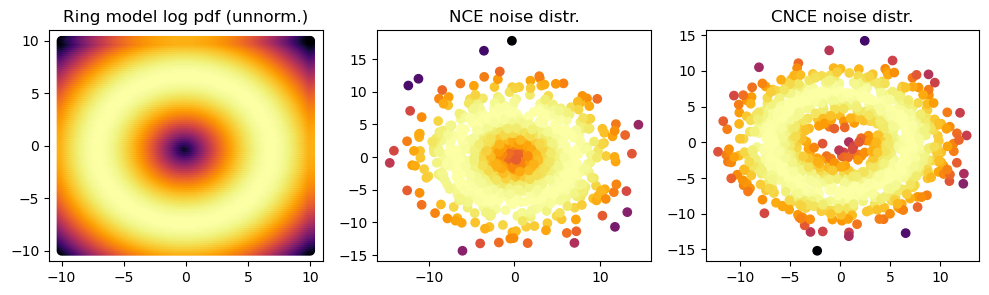

In [6]:
# 2D example
num_dims = 2
mu, precision = 7, 1


# Ring model pdf 
y_grid = get_grid_data()
log_pdf = unnorm_ring_model_log_pdf(y_grid, mu=mu, precision=precision)

# Sample from noise distr. based on some real training data
num_samples = 1000
y = RingModelDataset(sample_size=num_samples, num_dims=num_dims, mu=mu, precision=precision, 
                     root_dir="res/datasets/example_data").get_full_data()

# NCE 
y_samples_nce = sample_nce(y, num_samples)
log_pdf_nce = unnorm_ring_model_log_pdf(y_samples_nce, mu=mu, precision=precision)

# CNCE 
y_samples_cnce = sample_cnce(y, num_samples, mu, torch.log(torch.tensor(precision)))
log_pdf_cnce = unnorm_ring_model_log_pdf(y_samples_cnce, mu=mu, precision=precision)


# Visualise
fig, ax = plt.subplots(1, 3, figsize=(12, 3))

ax[0].scatter(y_grid[:, 0], y_grid[:, 1], c=log_pdf, cmap='inferno')
ax[0].set_title("Ring model log pdf (unnorm.)")

ax[1].scatter(y_samples_nce[:, 0], y_samples_nce[:, 1], c=log_pdf_nce, cmap='inferno')
ax[1].set_title("NCE noise distr.")

ax[2].scatter(y_samples_cnce[:, 0], y_samples_cnce[:, 1], c=log_pdf_cnce, cmap='inferno')
ax[2].set_title("CNCE noise distr.")
            

plt.show()


## EXPERIMENTS

In [12]:
# Data specs
num_dims = 5

# Experiments specs
num_samples = [20, 50, 100, 200]
num_neg_samples = [2, 5, 10]
reps = 10

# Criteria 
criteria = [NceBinaryCrit, CondNceCrit]
crit_labels = ["binary", "conditional"]

# Training specs
batch_size = 32
num_epochs = 100

In [13]:
# Run experiments

error_res = np.zeros((len(num_samples), len(num_neg_samples), len(criteria), reps))

# Sorry för alla loopar
for i, N in enumerate(num_samples):
    
    for j, J in enumerate(num_neg_samples):
        
        for rep in range(reps):
            
            # Get data 
            mu, precision, _ = generate_true_params()
            error_metric = PrecisionErrorMetric(true_precision=precision).metric            
                        
            training_data = RingModelDataset(sample_size=N, num_dims=num_dims, mu=mu.numpy(), precision=precision.numpy(), 
                                             root_dir="res/datasets/ring_data_size_" + str(N) + "_nn_" + str(J) + "_rep_" + str(rep))
            train_loader = torch.utils.data.DataLoader(training_data, batch_size=batch_size, shuffle=True)
    
            # Initialise           
            _, log_precision_init, log_z_init = initialise_params()
    
            # Get noise distr. params
            mu_noise_nce, cov_noise_nce = get_nce_noise_distr_par(training_data.get_full_data())
            cov_noise_cnce = get_cnce_noise_distr_par(training_data.get_full_data(), J, mu, log_precision_init)
                        
            for k, (crit, lab) in enumerate(zip(criteria, crit_labels)):
            
                if crit == NceBinaryCrit: # TODO: Nicer way to do this comparison?
                    p_m = RingModelNCE(mu=mu, log_precision=log_precision_init, log_part_fn=log_z_init)
                else:
                    p_m = RingModel(mu=mu, log_precision=log_precision_init)
                    
                if crit == CondNceCrit:
                    p_n = ConditionalMultivariateNormal(cov=cov_noise_cnce)
                else:
                    p_n = MultivariateNormal(mu=mu_noise_nce, cov=cov_noise_nce)
                    
                criterion = crit(p_m, p_n)
                
                save_dir = "res/param_error_" + lab + "_samples_" + str(N) + "_num_neg_" + str(J) + "_rep_" + str(rep)
                error_res[i, j, k, rep] = train_model(criterion, error_metric, train_loader, save_dir, neg_sample_size=J, num_epochs=num_epochs,
                                                      stopping_condition=no_change_stopping_condition)

np.save("res/final_param_error_ring_model_all", error_res)

[1] loss: 9.528
[1] evaluation metric: 17.492
[2] loss: 8.214
[2] evaluation metric: 52.194
[3] loss: 6.907
[3] evaluation metric: 154.409
[4] loss: 5.109
[4] evaluation metric: 132.991
[5] loss: 3.773
[5] evaluation metric: 125.726
[6] loss: 7.388
[6] evaluation metric: 174.157
[7] loss: 8.398
[7] evaluation metric: 161.088
[8] loss: 7.215
[8] evaluation metric: 127.979
[9] loss: 6.707
[9] evaluation metric: 103.077
[10] loss: 7.925
[10] evaluation metric: 184.704
[11] loss: 5.690
[11] evaluation metric: 162.126
[12] loss: 8.323
[12] evaluation metric: 173.192
[13] loss: 5.984
[13] evaluation metric: 108.609
[14] loss: 4.853
[14] evaluation metric: 121.206
[15] loss: 5.019
[15] evaluation metric: 100.850
[16] loss: 6.635
[16] evaluation metric: 110.867
[17] loss: 4.329
[17] evaluation metric: 96.429
[18] loss: 7.160
[18] evaluation metric: 120.129
[19] loss: 5.498
[19] evaluation metric: 121.183
[20] loss: 7.706
[20] evaluation metric: 122.499
[21] loss: 5.858
[21] evaluation metric: 

[22] evaluation metric: 264.214
[23] loss: 4.623
[23] evaluation metric: 311.969
[24] loss: 1.839
[24] evaluation metric: 263.510
[25] loss: 4.965
[25] evaluation metric: 336.417
[26] loss: 3.766
[26] evaluation metric: 346.495
[27] loss: 2.823
[27] evaluation metric: 348.218
[28] loss: 3.606
[28] evaluation metric: 286.570
[29] loss: 5.766
[29] evaluation metric: 293.691
[30] loss: 4.121
[30] evaluation metric: 375.480
[31] loss: 4.379
[31] evaluation metric: 434.034
[32] loss: 3.316
[32] evaluation metric: 299.481
[33] loss: 2.414
[33] evaluation metric: 253.272
[34] loss: 4.011
[34] evaluation metric: 252.129
[35] loss: 5.086
[35] evaluation metric: 313.429
[36] loss: 6.333
[36] evaluation metric: 380.018
[37] loss: 5.221
[37] evaluation metric: 463.957
[38] loss: 6.877
[38] evaluation metric: 382.841
[39] loss: 4.078
[39] evaluation metric: 342.567
[40] loss: 3.438
[40] evaluation metric: 327.843
[41] loss: 4.464
[41] evaluation metric: 268.763
[42] loss: 4.719
[42] evaluation metr

[85] evaluation metric: 11.952
[86] loss: 4.031
[86] evaluation metric: 11.536
[87] loss: 5.057
[87] evaluation metric: 11.074
[88] loss: 5.348
[88] evaluation metric: 12.789
[89] loss: 4.336
[89] evaluation metric: 12.731
[90] loss: 4.436
[90] evaluation metric: 11.507
[91] loss: 4.478
[91] evaluation metric: 12.599
[92] loss: 5.321
[92] evaluation metric: 12.187
[93] loss: 4.993
[93] evaluation metric: 13.633
[94] loss: 3.739
[94] evaluation metric: 10.899
[95] loss: 3.941
[95] evaluation metric: 9.360
[96] loss: 4.768
[96] evaluation metric: 10.213
[97] loss: 4.642
[97] evaluation metric: 10.131
[98] loss: 4.160
[98] evaluation metric: 10.725
[99] loss: 3.239
[99] evaluation metric: 10.169
[100] loss: 4.572
[100] evaluation metric: 9.975
Finished training
Data saved
[1] loss: 0.948
[1] evaluation metric: 8.369
[2] loss: 0.616
[2] evaluation metric: 7.560
[3] loss: 0.625
[3] evaluation metric: 6.946
[4] loss: 0.730
[4] evaluation metric: 6.109
[5] loss: 0.962
[5] evaluation metric: 5

[88] loss: 5.400
[88] evaluation metric: 15.208
[89] loss: 4.549
[89] evaluation metric: 13.410
[90] loss: 6.282
[90] evaluation metric: 13.707
[91] loss: 4.558
[91] evaluation metric: 14.062
[92] loss: 6.188
[92] evaluation metric: 13.205
[93] loss: 6.058
[93] evaluation metric: 13.766
[94] loss: 5.654
[94] evaluation metric: 13.359
[95] loss: 3.998
[95] evaluation metric: 11.827
[96] loss: 4.898
[96] evaluation metric: 11.295
[97] loss: 4.504
[97] evaluation metric: 14.151
[98] loss: 4.443
[98] evaluation metric: 14.836
[99] loss: 3.620
[99] evaluation metric: 11.175
[100] loss: 5.209
[100] evaluation metric: 12.654
Finished training
Data saved
[1] loss: 1.085
[1] evaluation metric: 10.156
[2] loss: 1.067
[2] evaluation metric: 8.236
[3] loss: 0.947
[3] evaluation metric: 6.889
[4] loss: 1.149
[4] evaluation metric: 5.582
[5] loss: 0.682
[5] evaluation metric: 4.988
[6] loss: 0.784
[6] evaluation metric: 4.391
[7] loss: 0.650
[7] evaluation metric: 3.925
[8] loss: 0.837
[8] evaluatio

[87] loss: 2.548
[87] evaluation metric: 35.633
[88] loss: 2.429
[88] evaluation metric: 34.156
[89] loss: 2.724
[89] evaluation metric: 34.776
[90] loss: 4.970
[90] evaluation metric: 37.695
[91] loss: 2.946
[91] evaluation metric: 41.948
[92] loss: 2.925
[92] evaluation metric: 34.062
[93] loss: 1.835
[93] evaluation metric: 36.606
[94] loss: 1.859
[94] evaluation metric: 31.339
[95] loss: 3.467
[95] evaluation metric: 32.948
[96] loss: 2.472
[96] evaluation metric: 36.754
[97] loss: 3.636
[97] evaluation metric: 33.369
[98] loss: 2.946
[98] evaluation metric: 39.482
[99] loss: 4.578
[99] evaluation metric: 39.437
[100] loss: 3.699
[100] evaluation metric: 34.346
Finished training
Data saved
[1] loss: 0.871
[1] evaluation metric: 29.218
[2] loss: 0.948
[2] evaluation metric: 24.062
[3] loss: 1.016
[3] evaluation metric: 19.465
[4] loss: 0.479
[4] evaluation metric: 17.808
[5] loss: 0.562
[5] evaluation metric: 16.353
[6] loss: 0.716
[6] evaluation metric: 14.082
[7] loss: 0.708
[7] e

[74] loss: 5.051
[74] evaluation metric: 83.514
[75] loss: 4.323
[75] evaluation metric: 71.012
[76] loss: 2.772
[76] evaluation metric: 64.269
[77] loss: 4.510
[77] evaluation metric: 61.394
[78] loss: 4.315
[78] evaluation metric: 60.641
[79] loss: 4.191
[79] evaluation metric: 65.250
[80] loss: 3.393
[80] evaluation metric: 52.325
[81] loss: 4.153
[81] evaluation metric: 60.003
[82] loss: 3.606
[82] evaluation metric: 51.060
[83] loss: 4.255
[83] evaluation metric: 56.750
[84] loss: 3.357
[84] evaluation metric: 63.237
[85] loss: 4.458
[85] evaluation metric: 61.649
[86] loss: 3.224
[86] evaluation metric: 52.831
[87] loss: 3.553
[87] evaluation metric: 59.722
[88] loss: 3.539
[88] evaluation metric: 56.231
[89] loss: 3.926
[89] evaluation metric: 55.626
[90] loss: 2.895
[90] evaluation metric: 52.345
[91] loss: 2.476
[91] evaluation metric: 42.880
[92] loss: 3.474
[92] evaluation metric: 44.009
[93] loss: 3.348
[93] evaluation metric: 37.978
[94] loss: 3.756
[94] evaluation metric:

[45] loss: 2.538
[45] evaluation metric: 931.673
[46] loss: 5.057
[46] evaluation metric: 1204.378
[47] loss: 3.388
[47] evaluation metric: 1031.602
[48] loss: 1.434
[48] evaluation metric: 1000.893
[49] loss: 2.850
[49] evaluation metric: 1082.694
[50] loss: 3.300
[50] evaluation metric: 1313.689
[51] loss: 1.877
[51] evaluation metric: 1229.502
[52] loss: 3.541
[52] evaluation metric: 1258.810
[53] loss: 2.236
[53] evaluation metric: 1217.851
[54] loss: 3.062
[54] evaluation metric: 1385.108
[55] loss: 4.642
[55] evaluation metric: 1295.824
[56] loss: 3.162
[56] evaluation metric: 1335.691
[57] loss: 3.265
[57] evaluation metric: 1323.338
[58] loss: 1.578
[58] evaluation metric: 1138.546
[59] loss: 3.053
[59] evaluation metric: 1180.379
[60] loss: 2.395
[60] evaluation metric: 1158.976
[61] loss: 4.205
[61] evaluation metric: 1451.789
[62] loss: 2.167
[62] evaluation metric: 1273.768
[63] loss: 0.709
[63] evaluation metric: 1050.351
[64] loss: 2.495
[64] evaluation metric: 976.834
[6

[37] loss: 6.938
[37] evaluation metric: 94.624
[38] loss: 4.291
[38] evaluation metric: 78.214
[39] loss: 5.723
[39] evaluation metric: 89.053
[40] loss: 7.049
[40] evaluation metric: 113.745
[41] loss: 6.598
[41] evaluation metric: 104.748
[42] loss: 5.887
[42] evaluation metric: 125.013
[43] loss: 8.645
[43] evaluation metric: 90.646
[44] loss: 5.226
[44] evaluation metric: 74.046
[45] loss: 7.275
[45] evaluation metric: 61.612
[46] loss: 6.118
[46] evaluation metric: 63.817
[47] loss: 6.095
[47] evaluation metric: 72.368
[48] loss: 4.428
[48] evaluation metric: 69.198
[49] loss: 7.607
[49] evaluation metric: 85.015
[50] loss: 4.798
[50] evaluation metric: 66.152
[51] loss: 4.799
[51] evaluation metric: 67.124
[52] loss: 5.921
[52] evaluation metric: 70.903
[53] loss: 6.708
[53] evaluation metric: 68.124
[54] loss: 6.247
[54] evaluation metric: 64.940
[55] loss: 5.780
[55] evaluation metric: 56.115
[56] loss: 5.133
[56] evaluation metric: 62.875
[57] loss: 4.366
[57] evaluation metr

[54] loss: 4.860
[54] evaluation metric: 585.729
[55] loss: 3.700
[55] evaluation metric: 678.093
[56] loss: 2.998
[56] evaluation metric: 610.606
[57] loss: 2.194
[57] evaluation metric: 788.493
[58] loss: 3.448
[58] evaluation metric: 770.637
[59] loss: 4.780
[59] evaluation metric: 706.475
[60] loss: 6.013
[60] evaluation metric: 744.348
[61] loss: 4.342
[61] evaluation metric: 564.230
[62] loss: 2.839
[62] evaluation metric: 608.584
[63] loss: 4.221
[63] evaluation metric: 667.309
[64] loss: 3.951
[64] evaluation metric: 669.428
[65] loss: 2.544
[65] evaluation metric: 686.602
[66] loss: 4.157
[66] evaluation metric: 598.719
[67] loss: 2.441
[67] evaluation metric: 500.354
[68] loss: 4.023
[68] evaluation metric: 519.557
[69] loss: 3.186
[69] evaluation metric: 530.428
[70] loss: 3.057
[70] evaluation metric: 518.389
[71] loss: 4.030
[71] evaluation metric: 509.549
[72] loss: 2.094
[72] evaluation metric: 503.918
[73] loss: 3.862
[73] evaluation metric: 550.953
[74] loss: 3.321
[74

[45] evaluation metric: 0.042
[46] loss: 0.646
[46] evaluation metric: 0.043
[47] loss: 0.625
[47] evaluation metric: 0.043
[48] loss: 0.736
[48] evaluation metric: 0.045
[49] loss: 0.689
[49] evaluation metric: 0.046
[50] loss: 0.656
[50] evaluation metric: 0.046
[51] loss: 0.779
[51] evaluation metric: 0.049
[52] loss: 0.631
[52] evaluation metric: 0.049
[53] loss: 0.701
[53] evaluation metric: 0.051
[54] loss: 0.734
[54] evaluation metric: 0.052
[55] loss: 0.706
[55] evaluation metric: 0.054
[56] loss: 0.651
[56] evaluation metric: 0.054
Training converged
Finished training
Data saved
[1] loss: 32.272
[1] evaluation metric: 0.212
[2] loss: 24.203
[2] evaluation metric: 3.593
[3] loss: 18.119
[3] evaluation metric: 16.944
[4] loss: 15.639
[4] evaluation metric: 28.294
[5] loss: 11.547
[5] evaluation metric: 47.157
[6] loss: 12.877
[6] evaluation metric: 41.474
[7] loss: 12.222
[7] evaluation metric: 28.816
[8] loss: 12.577
[8] evaluation metric: 34.975
[9] loss: 12.210
[9] evaluation

[64] loss: 0.618
[64] evaluation metric: 0.032
[65] loss: 0.580
[65] evaluation metric: 0.033
[66] loss: 0.595
[66] evaluation metric: 0.033
[67] loss: 0.594
[67] evaluation metric: 0.034
[68] loss: 0.562
[68] evaluation metric: 0.033
[69] loss: 0.565
[69] evaluation metric: 0.033
[70] loss: 0.630
[70] evaluation metric: 0.034
[71] loss: 0.590
[71] evaluation metric: 0.034
[72] loss: 0.662
[72] evaluation metric: 0.035
[73] loss: 0.623
[73] evaluation metric: 0.036
[74] loss: 0.588
[74] evaluation metric: 0.036
[75] loss: 0.557
[75] evaluation metric: 0.036
Training converged
Finished training
Data saved
[1] loss: 47.267
[1] evaluation metric: 0.470
[2] loss: 33.200
[2] evaluation metric: 41.852
[3] loss: 17.059
[3] evaluation metric: 96.574
[4] loss: 13.417
[4] evaluation metric: 167.144
[5] loss: 12.814
[5] evaluation metric: 94.276
[6] loss: 17.152
[6] evaluation metric: 192.531
[7] loss: 15.230
[7] evaluation metric: 162.597
[8] loss: 15.727
[8] evaluation metric: 161.632
[9] loss:

[62] loss: 0.531
[62] evaluation metric: 0.045
[63] loss: 0.435
[63] evaluation metric: 0.044
[64] loss: 0.509
[64] evaluation metric: 0.042
[65] loss: 0.463
[65] evaluation metric: 0.041
[66] loss: 0.394
[66] evaluation metric: 0.041
[67] loss: 0.454
[67] evaluation metric: 0.041
[68] loss: 0.470
[68] evaluation metric: 0.040
[69] loss: 0.447
[69] evaluation metric: 0.038
[70] loss: 0.506
[70] evaluation metric: 0.036
[71] loss: 0.470
[71] evaluation metric: 0.034
[72] loss: 0.449
[72] evaluation metric: 0.032
[73] loss: 0.386
[73] evaluation metric: 0.033
[74] loss: 0.405
[74] evaluation metric: 0.034
[75] loss: 0.451
[75] evaluation metric: 0.032
[76] loss: 0.506
[76] evaluation metric: 0.029
[77] loss: 0.515
[77] evaluation metric: 0.028
[78] loss: 0.392
[78] evaluation metric: 0.028
[79] loss: 0.467
[79] evaluation metric: 0.027
[80] loss: 0.436
[80] evaluation metric: 0.027
[81] loss: 0.491
[81] evaluation metric: 0.026
[82] loss: 0.506
[82] evaluation metric: 0.023
[83] loss: 0.

[56] loss: 0.681
[56] evaluation metric: 0.027
[57] loss: 0.712
[57] evaluation metric: 0.028
[58] loss: 0.669
[58] evaluation metric: 0.029
[59] loss: 0.660
[59] evaluation metric: 0.029
[60] loss: 0.707
[60] evaluation metric: 0.030
[61] loss: 0.677
[61] evaluation metric: 0.030
[62] loss: 0.701
[62] evaluation metric: 0.031
[63] loss: 0.666
[63] evaluation metric: 0.031
[64] loss: 0.658
[64] evaluation metric: 0.031
[65] loss: 0.669
[65] evaluation metric: 0.032
[66] loss: 0.692
[66] evaluation metric: 0.032
[67] loss: 0.703
[67] evaluation metric: 0.033
[68] loss: 0.671
[68] evaluation metric: 0.033
[69] loss: 0.699
[69] evaluation metric: 0.034
[70] loss: 0.713
[70] evaluation metric: 0.035
[71] loss: 0.675
[71] evaluation metric: 0.035
[72] loss: 0.690
[72] evaluation metric: 0.036
[73] loss: 0.662
[73] evaluation metric: 0.036
[74] loss: 0.683
[74] evaluation metric: 0.037
[75] loss: 0.682
[75] evaluation metric: 0.038
[76] loss: 0.689
[76] evaluation metric: 0.038
[77] loss: 0.

[40] loss: 0.567
[40] evaluation metric: 0.108
[41] loss: 0.514
[41] evaluation metric: 0.100
[42] loss: 0.522
[42] evaluation metric: 0.095
[43] loss: 0.499
[43] evaluation metric: 0.090
[44] loss: 0.533
[44] evaluation metric: 0.084
[45] loss: 0.511
[45] evaluation metric: 0.079
[46] loss: 0.606
[46] evaluation metric: 0.072
[47] loss: 0.408
[47] evaluation metric: 0.072
[48] loss: 0.430
[48] evaluation metric: 0.071
[49] loss: 0.465
[49] evaluation metric: 0.069
[50] loss: 0.475
[50] evaluation metric: 0.067
[51] loss: 0.557
[51] evaluation metric: 0.062
[52] loss: 0.423
[52] evaluation metric: 0.063
[53] loss: 0.517
[53] evaluation metric: 0.062
[54] loss: 0.454
[54] evaluation metric: 0.061
[55] loss: 0.484
[55] evaluation metric: 0.060
[56] loss: 0.455
[56] evaluation metric: 0.059
[57] loss: 0.509
[57] evaluation metric: 0.057
[58] loss: 0.503
[58] evaluation metric: 0.054
[59] loss: 0.552
[59] evaluation metric: 0.050
[60] loss: 0.485
[60] evaluation metric: 0.049
[61] loss: 0.

[47] loss: 0.503
[47] evaluation metric: 0.104
[48] loss: 0.392
[48] evaluation metric: 0.106
[49] loss: 0.464
[49] evaluation metric: 0.096
[50] loss: 0.447
[50] evaluation metric: 0.090
[51] loss: 0.541
[51] evaluation metric: 0.077
[52] loss: 0.389
[52] evaluation metric: 0.078
[53] loss: 0.471
[53] evaluation metric: 0.071
[54] loss: 0.469
[54] evaluation metric: 0.064
[55] loss: 0.387
[55] evaluation metric: 0.063
[56] loss: 0.444
[56] evaluation metric: 0.061
[57] loss: 0.440
[57] evaluation metric: 0.057
[58] loss: 0.449
[58] evaluation metric: 0.047
[59] loss: 0.401
[59] evaluation metric: 0.044
[60] loss: 0.435
[60] evaluation metric: 0.037
[61] loss: 0.367
[61] evaluation metric: 0.038
[62] loss: 0.450
[62] evaluation metric: 0.039
[63] loss: 0.402
[63] evaluation metric: 0.042
[64] loss: 0.382
[64] evaluation metric: 0.043
[65] loss: 0.451
[65] evaluation metric: 0.039
[66] loss: 0.484
[66] evaluation metric: 0.032
[67] loss: 0.503
[67] evaluation metric: 0.026
[68] loss: 0.

[39] loss: 0.457
[39] evaluation metric: 2.218
[40] loss: 0.334
[40] evaluation metric: 2.250
[41] loss: 0.422
[41] evaluation metric: 2.243
[42] loss: 0.447
[42] evaluation metric: 2.198
[43] loss: 0.371
[43] evaluation metric: 2.223
[44] loss: 0.476
[44] evaluation metric: 2.159
[45] loss: 0.456
[45] evaluation metric: 2.134
[46] loss: 0.473
[46] evaluation metric: 2.091
[47] loss: 0.489
[47] evaluation metric: 2.044
[48] loss: 0.443
[48] evaluation metric: 1.988
[49] loss: 0.486
[49] evaluation metric: 1.920
[50] loss: 0.447
[50] evaluation metric: 1.903
[51] loss: 0.433
[51] evaluation metric: 1.879
[52] loss: 0.472
[52] evaluation metric: 1.848
[53] loss: 0.544
[53] evaluation metric: 1.761
[54] loss: 0.385
[54] evaluation metric: 1.730
[55] loss: 0.404
[55] evaluation metric: 1.717
[56] loss: 0.501
[56] evaluation metric: 1.656
[57] loss: 0.443
[57] evaluation metric: 1.612
[58] loss: 0.408
[58] evaluation metric: 1.603
[59] loss: 0.404
[59] evaluation metric: 1.599
[60] loss: 0.

[50] loss: 0.586
[50] evaluation metric: 0.001
[51] loss: 0.671
[51] evaluation metric: 0.002
[52] loss: 0.580
[52] evaluation metric: 0.002
[53] loss: 0.558
[53] evaluation metric: 0.002
[54] loss: 0.521
[54] evaluation metric: 0.001
[55] loss: 0.607
[55] evaluation metric: 0.001
[56] loss: 0.559
[56] evaluation metric: 0.001
[57] loss: 0.627
[57] evaluation metric: 0.002
[58] loss: 0.518
[58] evaluation metric: 0.002
[59] loss: 0.639
[59] evaluation metric: 0.002
[60] loss: 0.569
[60] evaluation metric: 0.002
[61] loss: 0.569
[61] evaluation metric: 0.002
[62] loss: 0.593
[62] evaluation metric: 0.002
[63] loss: 0.624
[63] evaluation metric: 0.002
[64] loss: 0.576
[64] evaluation metric: 0.002
[65] loss: 0.633
[65] evaluation metric: 0.003
[66] loss: 0.577
[66] evaluation metric: 0.003
[67] loss: 0.593
[67] evaluation metric: 0.003
[68] loss: 0.659
[68] evaluation metric: 0.003
[69] loss: 0.663
[69] evaluation metric: 0.004
[70] loss: 0.582
[70] evaluation metric: 0.004
[71] loss: 0.

[56] loss: 0.436
[56] evaluation metric: 0.353
[57] loss: 0.295
[57] evaluation metric: 0.376
[58] loss: 0.365
[58] evaluation metric: 0.408
[59] loss: 0.354
[59] evaluation metric: 0.464
[60] loss: 0.387
[60] evaluation metric: 0.496
[61] loss: 0.307
[61] evaluation metric: 0.528
[62] loss: 0.361
[62] evaluation metric: 0.581
[63] loss: 0.325
[63] evaluation metric: 0.607
[64] loss: 0.415
[64] evaluation metric: 0.706
[65] loss: 0.304
[65] evaluation metric: 0.729
[66] loss: 0.277
[66] evaluation metric: 0.747
[67] loss: 0.305
[67] evaluation metric: 0.775
[68] loss: 0.214
[68] evaluation metric: 0.756
[69] loss: 0.320
[69] evaluation metric: 0.800
[70] loss: 0.302
[70] evaluation metric: 0.845
[71] loss: 0.281
[71] evaluation metric: 0.839
[72] loss: 0.281
[72] evaluation metric: 0.846
[73] loss: 0.403
[73] evaluation metric: 0.927
[74] loss: 0.358
[74] evaluation metric: 0.975
[75] loss: 0.295
[75] evaluation metric: 1.009
[76] loss: 0.368
[76] evaluation metric: 1.081
[77] loss: 0.

[64] loss: 0.222
[64] evaluation metric: 17.573
[65] loss: 0.256
[65] evaluation metric: 16.928
[66] loss: 0.187
[66] evaluation metric: 16.756
[67] loss: 0.225
[67] evaluation metric: 16.053
[68] loss: 0.310
[68] evaluation metric: 14.932
[69] loss: 0.234
[69] evaluation metric: 14.623
[70] loss: 0.308
[70] evaluation metric: 13.906
[71] loss: 0.219
[71] evaluation metric: 13.645
[72] loss: 0.243
[72] evaluation metric: 12.990
[73] loss: 0.206
[73] evaluation metric: 12.627
[74] loss: 0.254
[74] evaluation metric: 12.363
[75] loss: 0.182
[75] evaluation metric: 12.225
[76] loss: 0.192
[76] evaluation metric: 12.046
[77] loss: 0.292
[77] evaluation metric: 11.344
[78] loss: 0.346
[78] evaluation metric: 10.428
[79] loss: 0.237
[79] evaluation metric: 10.059
[80] loss: 0.256
[80] evaluation metric: 9.625
[81] loss: 0.211
[81] evaluation metric: 9.592
[82] loss: 0.284
[82] evaluation metric: 8.985
[83] loss: 0.193
[83] evaluation metric: 8.862
[84] loss: 0.244
[84] evaluation metric: 8.6

[77] loss: 0.430
[77] evaluation metric: 0.012
[78] loss: 0.548
[78] evaluation metric: 0.011
[79] loss: 0.496
[79] evaluation metric: 0.011
[80] loss: 0.540
[80] evaluation metric: 0.009
[81] loss: 0.441
[81] evaluation metric: 0.009
[82] loss: 0.497
[82] evaluation metric: 0.008
[83] loss: 0.447
[83] evaluation metric: 0.008
Training converged
Finished training
Data saved
[1] loss: 91.649
[1] evaluation metric: 10.523
[2] loss: 48.761
[2] evaluation metric: 78.063
[3] loss: 18.797
[3] evaluation metric: 1204.668
[4] loss: 10.448
[4] evaluation metric: 2597.048
[5] loss: 12.369
[5] evaluation metric: 4354.323
[6] loss: 12.107
[6] evaluation metric: 1950.988
[7] loss: 13.390
[7] evaluation metric: 2539.237
[8] loss: 11.461
[8] evaluation metric: 3457.847
[9] loss: 13.146
[9] evaluation metric: 2437.191
[10] loss: 9.440
[10] evaluation metric: 2491.310
[11] loss: 9.261
[11] evaluation metric: 1769.129
[12] loss: 12.268
[12] evaluation metric: 2096.122
[13] loss: 7.999
[13] evaluation me

[83] loss: 0.261
[83] evaluation metric: 0.007
[84] loss: 0.260
[84] evaluation metric: 0.005
[85] loss: 0.257
[85] evaluation metric: 0.005
Training converged
Finished training
Data saved
[1] loss: 79.150
[1] evaluation metric: 8.592
[2] loss: 44.805
[2] evaluation metric: 184.313
[3] loss: 32.883
[3] evaluation metric: 39.587
[4] loss: 30.020
[4] evaluation metric: 95.967
[5] loss: 27.850
[5] evaluation metric: 63.695
[6] loss: 28.643
[6] evaluation metric: 51.131
[7] loss: 25.756
[7] evaluation metric: 61.915
[8] loss: 26.190
[8] evaluation metric: 48.854
[9] loss: 27.883
[9] evaluation metric: 42.351
[10] loss: 23.204
[10] evaluation metric: 38.245
[11] loss: 19.334
[11] evaluation metric: 43.041
[12] loss: 19.234
[12] evaluation metric: 30.644
[13] loss: 17.942
[13] evaluation metric: 23.067
[14] loss: 15.417
[14] evaluation metric: 24.519
[15] loss: 17.276
[15] evaluation metric: 26.605
[16] loss: 15.178
[16] evaluation metric: 17.479
[17] loss: 13.326
[17] evaluation metric: 15.

[94] loss: 0.647
[94] evaluation metric: 0.014
[95] loss: 0.665
[95] evaluation metric: 0.015
[96] loss: 0.667
[96] evaluation metric: 0.015
[97] loss: 0.660
[97] evaluation metric: 0.015
[98] loss: 0.638
[98] evaluation metric: 0.015
[99] loss: 0.643
[99] evaluation metric: 0.015
[100] loss: 0.674
[100] evaluation metric: 0.015
Finished training
Data saved
[1] loss: 69.674
[1] evaluation metric: 4.163
[2] loss: 25.884
[2] evaluation metric: 190.654
[3] loss: 14.845
[3] evaluation metric: 682.302
[4] loss: 11.344
[4] evaluation metric: 599.399
[5] loss: 10.768
[5] evaluation metric: 601.395
[6] loss: 11.841
[6] evaluation metric: 708.280
[7] loss: 10.169
[7] evaluation metric: 736.654
[8] loss: 13.146
[8] evaluation metric: 610.456
[9] loss: 11.264
[9] evaluation metric: 533.230
[10] loss: 11.156
[10] evaluation metric: 583.651
[11] loss: 12.027
[11] evaluation metric: 531.440
[12] loss: 11.009
[12] evaluation metric: 605.400
[13] loss: 10.113
[13] evaluation metric: 479.287
[14] loss:

[81] loss: 0.331
[81] evaluation metric: 0.035
[82] loss: 0.362
[82] evaluation metric: 0.037
[83] loss: 0.367
[83] evaluation metric: 0.042
[84] loss: 0.377
[84] evaluation metric: 0.047
[85] loss: 0.379
[85] evaluation metric: 0.050
[86] loss: 0.359
[86] evaluation metric: 0.053
[87] loss: 0.434
[87] evaluation metric: 0.060
[88] loss: 0.370
[88] evaluation metric: 0.064
[89] loss: 0.372
[89] evaluation metric: 0.067
[90] loss: 0.364
[90] evaluation metric: 0.067
[91] loss: 0.366
[91] evaluation metric: 0.073
[92] loss: 0.381
[92] evaluation metric: 0.076
[93] loss: 0.361
[93] evaluation metric: 0.078
[94] loss: 0.421
[94] evaluation metric: 0.088
[95] loss: 0.293
[95] evaluation metric: 0.083
[96] loss: 0.363
[96] evaluation metric: 0.085
[97] loss: 0.337
[97] evaluation metric: 0.084
[98] loss: 0.346
[98] evaluation metric: 0.087
[99] loss: 0.354
[99] evaluation metric: 0.091
[100] loss: 0.369
[100] evaluation metric: 0.094
Finished training
Data saved
[1] loss: 66.279
[1] evaluati

[1] loss: 64.431
[1] evaluation metric: 28.740
[2] loss: 16.261
[2] evaluation metric: 734.102
[3] loss: 11.058
[3] evaluation metric: 2040.377
[4] loss: 9.128
[4] evaluation metric: 4274.376
[5] loss: 6.910
[5] evaluation metric: 4300.556
[6] loss: 7.751
[6] evaluation metric: 3267.429
[7] loss: 7.374
[7] evaluation metric: 4878.910
[8] loss: 11.956
[8] evaluation metric: 6949.414
[9] loss: 8.818
[9] evaluation metric: 5019.944
[10] loss: 6.164
[10] evaluation metric: 4498.117
[11] loss: 7.721
[11] evaluation metric: 4045.334
[12] loss: 6.015
[12] evaluation metric: 3700.078
[13] loss: 6.388
[13] evaluation metric: 2916.163
[14] loss: 7.791
[14] evaluation metric: 3698.687
[15] loss: 7.469
[15] evaluation metric: 3666.316
[16] loss: 8.594
[16] evaluation metric: 4110.148
[17] loss: 8.982
[17] evaluation metric: 4664.686
[18] loss: 7.474
[18] evaluation metric: 3395.654
[19] loss: 7.656
[19] evaluation metric: 3781.026
[20] loss: 10.923
[20] evaluation metric: 4297.770
[21] loss: 9.673

[74] loss: 0.217
[74] evaluation metric: 33.843
[75] loss: 0.162
[75] evaluation metric: 33.719
[76] loss: 0.218
[76] evaluation metric: 32.908
[77] loss: 0.236
[77] evaluation metric: 32.146
[78] loss: 0.202
[78] evaluation metric: 31.726
[79] loss: 0.231
[79] evaluation metric: 30.872
[80] loss: 0.128
[80] evaluation metric: 31.068
[81] loss: 0.197
[81] evaluation metric: 30.760
[82] loss: 0.192
[82] evaluation metric: 30.400
[83] loss: 0.228
[83] evaluation metric: 29.625
[84] loss: 0.267
[84] evaluation metric: 28.718
[85] loss: 0.231
[85] evaluation metric: 28.025
[86] loss: 0.256
[86] evaluation metric: 27.212
[87] loss: 0.184
[87] evaluation metric: 27.055
[88] loss: 0.223
[88] evaluation metric: 26.800
[89] loss: 0.213
[89] evaluation metric: 26.584
[90] loss: 0.186
[90] evaluation metric: 26.435
[91] loss: 0.191
[91] evaluation metric: 26.155
[92] loss: 0.200
[92] evaluation metric: 25.972
[93] loss: 0.186
[93] evaluation metric: 25.551
[94] loss: 0.188
[94] evaluation metric:

[47] loss: 3.503
[47] evaluation metric: 2.115
[48] loss: 3.536
[48] evaluation metric: 1.961
[49] loss: 3.955
[49] evaluation metric: 1.797
[50] loss: 3.636
[50] evaluation metric: 1.657
[51] loss: 3.563
[51] evaluation metric: 1.507
[52] loss: 3.566
[52] evaluation metric: 1.397
[53] loss: 3.552
[53] evaluation metric: 1.278
[54] loss: 3.629
[54] evaluation metric: 1.223
[55] loss: 3.527
[55] evaluation metric: 1.160
[56] loss: 3.593
[56] evaluation metric: 1.134
[57] loss: 3.172
[57] evaluation metric: 1.020
[58] loss: 3.404
[58] evaluation metric: 0.943
[59] loss: 3.292
[59] evaluation metric: 0.911
[60] loss: 3.560
[60] evaluation metric: 0.916
[61] loss: 3.421
[61] evaluation metric: 0.834
[62] loss: 3.635
[62] evaluation metric: 0.782
[63] loss: 3.568
[63] evaluation metric: 0.719
[64] loss: 3.389
[64] evaluation metric: 0.657
[65] loss: 3.666
[65] evaluation metric: 0.625
[66] loss: 3.089
[66] evaluation metric: 0.559
[67] loss: 3.535
[67] evaluation metric: 0.539
[68] loss: 3.

[41] loss: 5.968
[41] evaluation metric: 12.042
[42] loss: 8.103
[42] evaluation metric: 12.074
[43] loss: 6.518
[43] evaluation metric: 9.862
[44] loss: 5.404
[44] evaluation metric: 8.805
[45] loss: 6.099
[45] evaluation metric: 8.428
[46] loss: 5.379
[46] evaluation metric: 6.870
[47] loss: 5.841
[47] evaluation metric: 6.574
[48] loss: 5.528
[48] evaluation metric: 5.957
[49] loss: 4.916
[49] evaluation metric: 4.720
[50] loss: 5.433
[50] evaluation metric: 4.444
[51] loss: 4.978
[51] evaluation metric: 3.893
[52] loss: 4.926
[52] evaluation metric: 3.303
[53] loss: 4.652
[53] evaluation metric: 2.942
[54] loss: 4.817
[54] evaluation metric: 2.531
[55] loss: 4.409
[55] evaluation metric: 2.345
[56] loss: 4.057
[56] evaluation metric: 1.912
[57] loss: 3.778
[57] evaluation metric: 1.698
[58] loss: 3.994
[58] evaluation metric: 1.633
[59] loss: 4.155
[59] evaluation metric: 1.552
[60] loss: 3.961
[60] evaluation metric: 1.285
[61] loss: 3.676
[61] evaluation metric: 1.199
[62] loss: 

[6] loss: 0.645
[6] evaluation metric: 0.033
[7] loss: 0.653
[7] evaluation metric: 0.030
[8] loss: 0.663
[8] evaluation metric: 0.028
[9] loss: 0.646
[9] evaluation metric: 0.026
[10] loss: 0.608
[10] evaluation metric: 0.025
[11] loss: 0.651
[11] evaluation metric: 0.023
[12] loss: 0.618
[12] evaluation metric: 0.022
[13] loss: 0.613
[13] evaluation metric: 0.021
[14] loss: 0.603
[14] evaluation metric: 0.020
[15] loss: 0.647
[15] evaluation metric: 0.018
[16] loss: 0.615
[16] evaluation metric: 0.017
[17] loss: 0.707
[17] evaluation metric: 0.015
[18] loss: 0.602
[18] evaluation metric: 0.015
[19] loss: 0.644
[19] evaluation metric: 0.014
[20] loss: 0.642
[20] evaluation metric: 0.013
[21] loss: 0.623
[21] evaluation metric: 0.012
[22] loss: 0.598
[22] evaluation metric: 0.012
[23] loss: 0.624
[23] evaluation metric: 0.011
[24] loss: 0.624
[24] evaluation metric: 0.011
[25] loss: 0.635
[25] evaluation metric: 0.010
[26] loss: 0.678
[26] evaluation metric: 0.009
[27] loss: 0.629
[27]

[20] loss: 9.351
[20] evaluation metric: 154.409
[21] loss: 8.257
[21] evaluation metric: 179.740
[22] loss: 6.968
[22] evaluation metric: 182.798
[23] loss: 9.432
[23] evaluation metric: 166.505
[24] loss: 7.115
[24] evaluation metric: 204.906
[25] loss: 8.304
[25] evaluation metric: 201.032
[26] loss: 7.906
[26] evaluation metric: 191.714
[27] loss: 8.892
[27] evaluation metric: 189.634
[28] loss: 8.593
[28] evaluation metric: 169.895
[29] loss: 7.996
[29] evaluation metric: 209.945
[30] loss: 8.579
[30] evaluation metric: 132.642
[31] loss: 6.194
[31] evaluation metric: 170.493
[32] loss: 7.708
[32] evaluation metric: 142.210
[33] loss: 7.789
[33] evaluation metric: 136.254
[34] loss: 6.187
[34] evaluation metric: 180.323
[35] loss: 7.621
[35] evaluation metric: 158.411
[36] loss: 7.704
[36] evaluation metric: 157.227
[37] loss: 5.930
[37] evaluation metric: 97.721
[38] loss: 6.532
[38] evaluation metric: 113.497
[39] loss: 8.170
[39] evaluation metric: 80.995
[40] loss: 8.120
[40] 

[21] loss: 11.716
[21] evaluation metric: 9.930
[22] loss: 11.660
[22] evaluation metric: 10.604
[23] loss: 12.547
[23] evaluation metric: 9.702
[24] loss: 10.977
[24] evaluation metric: 6.603
[25] loss: 11.132
[25] evaluation metric: 6.096
[26] loss: 10.762
[26] evaluation metric: 6.243
[27] loss: 11.236
[27] evaluation metric: 5.522
[28] loss: 9.089
[28] evaluation metric: 5.968
[29] loss: 9.451
[29] evaluation metric: 4.962
[30] loss: 9.309
[30] evaluation metric: 4.692
[31] loss: 9.016
[31] evaluation metric: 5.060
[32] loss: 8.590
[32] evaluation metric: 3.895
[33] loss: 7.336
[33] evaluation metric: 3.289
[34] loss: 8.335
[34] evaluation metric: 2.750
[35] loss: 7.012
[35] evaluation metric: 2.310
[36] loss: 7.437
[36] evaluation metric: 2.148
[37] loss: 6.391
[37] evaluation metric: 2.217
[38] loss: 7.149
[38] evaluation metric: 1.747
[39] loss: 6.308
[39] evaluation metric: 1.537
[40] loss: 5.968
[40] evaluation metric: 1.696
[41] loss: 5.879
[41] evaluation metric: 1.455
[42] 

[1] loss: 23.196
[1] evaluation metric: 8.570
[2] loss: 14.245
[2] evaluation metric: 231.595
[3] loss: 10.487
[3] evaluation metric: 455.163
[4] loss: 8.724
[4] evaluation metric: 463.035
[5] loss: 7.896
[5] evaluation metric: 645.876
[6] loss: 8.840
[6] evaluation metric: 787.855
[7] loss: 9.847
[7] evaluation metric: 358.211
[8] loss: 8.340
[8] evaluation metric: 535.455
[9] loss: 8.377
[9] evaluation metric: 569.954
[10] loss: 10.747
[10] evaluation metric: 960.342
[11] loss: 8.073
[11] evaluation metric: 546.594
[12] loss: 13.547
[12] evaluation metric: 546.068
[13] loss: 11.850
[13] evaluation metric: 649.808
[14] loss: 7.555
[14] evaluation metric: 434.957
[15] loss: 9.671
[15] evaluation metric: 836.502
[16] loss: 9.439
[16] evaluation metric: 713.053
[17] loss: 7.957
[17] evaluation metric: 293.396
[18] loss: 6.495
[18] evaluation metric: 350.768
[19] loss: 8.967
[19] evaluation metric: 349.995
[20] loss: 9.828
[20] evaluation metric: 510.793
[21] loss: 10.932
[21] evaluation 

[74] loss: 0.541
[74] evaluation metric: 0.541
[75] loss: 0.857
[75] evaluation metric: 0.721
[76] loss: 0.563
[76] evaluation metric: 0.692
[77] loss: 0.479
[77] evaluation metric: 0.733
[78] loss: 0.561
[78] evaluation metric: 0.750
[79] loss: 0.556
[79] evaluation metric: 0.763
[80] loss: 0.593
[80] evaluation metric: 0.783
[81] loss: 0.379
[81] evaluation metric: 0.716
[82] loss: 0.610
[82] evaluation metric: 0.791
[83] loss: 0.555
[83] evaluation metric: 0.797
[84] loss: 0.695
[84] evaluation metric: 0.819
[85] loss: 0.798
[85] evaluation metric: 0.881
[86] loss: 0.511
[86] evaluation metric: 0.850
[87] loss: 0.484
[87] evaluation metric: 0.799
[88] loss: 0.647
[88] evaluation metric: 0.763
[89] loss: 0.374
[89] evaluation metric: 0.716
[90] loss: 0.581
[90] evaluation metric: 0.669
[91] loss: 0.532
[91] evaluation metric: 0.627
[92] loss: 0.528
[92] evaluation metric: 0.616
[93] loss: 0.637
[93] evaluation metric: 0.658
[94] loss: 0.603
[94] evaluation metric: 0.683
[95] loss: 0.

[56] loss: 4.611
[56] evaluation metric: 8.296
[57] loss: 6.756
[57] evaluation metric: 9.125
[58] loss: 5.125
[58] evaluation metric: 6.824
[59] loss: 5.424
[59] evaluation metric: 5.413
[60] loss: 6.265
[60] evaluation metric: 4.968
[61] loss: 6.019
[61] evaluation metric: 4.333
[62] loss: 5.641
[62] evaluation metric: 4.343
[63] loss: 5.525
[63] evaluation metric: 4.251
[64] loss: 5.168
[64] evaluation metric: 4.054
[65] loss: 4.792
[65] evaluation metric: 4.601
[66] loss: 4.557
[66] evaluation metric: 3.896
[67] loss: 4.467
[67] evaluation metric: 3.394
[68] loss: 4.803
[68] evaluation metric: 3.456
[69] loss: 4.485
[69] evaluation metric: 3.431
[70] loss: 5.446
[70] evaluation metric: 3.449
[71] loss: 5.893
[71] evaluation metric: 3.390
[72] loss: 4.117
[72] evaluation metric: 2.633
[73] loss: 4.189
[73] evaluation metric: 2.396
[74] loss: 4.949
[74] evaluation metric: 2.028
[75] loss: 4.050
[75] evaluation metric: 1.830
[76] loss: 4.465
[76] evaluation metric: 1.746
[77] loss: 4.

[31] loss: 12.188
[31] evaluation metric: 36.396
[32] loss: 13.272
[32] evaluation metric: 47.274
[33] loss: 11.734
[33] evaluation metric: 21.475
[34] loss: 10.761
[34] evaluation metric: 26.909
[35] loss: 10.265
[35] evaluation metric: 20.124
[36] loss: 11.822
[36] evaluation metric: 28.512
[37] loss: 10.758
[37] evaluation metric: 23.134
[38] loss: 10.373
[38] evaluation metric: 25.087
[39] loss: 8.680
[39] evaluation metric: 27.183
[40] loss: 11.497
[40] evaluation metric: 22.056
[41] loss: 11.218
[41] evaluation metric: 27.273
[42] loss: 10.624
[42] evaluation metric: 24.286
[43] loss: 9.605
[43] evaluation metric: 20.351
[44] loss: 9.862
[44] evaluation metric: 18.861
[45] loss: 10.079
[45] evaluation metric: 24.765
[46] loss: 9.420
[46] evaluation metric: 15.716
[47] loss: 8.750
[47] evaluation metric: 19.945
[48] loss: 9.726
[48] evaluation metric: 19.474
[49] loss: 8.378
[49] evaluation metric: 20.040
[50] loss: 9.979
[50] evaluation metric: 18.848
[51] loss: 8.865
[51] evalua

[22] loss: 9.896
[22] evaluation metric: 43.439
[23] loss: 12.198
[23] evaluation metric: 17.162
[24] loss: 13.297
[24] evaluation metric: 26.988
[25] loss: 11.605
[25] evaluation metric: 23.323
[26] loss: 11.716
[26] evaluation metric: 14.032
[27] loss: 10.131
[27] evaluation metric: 19.837
[28] loss: 9.781
[28] evaluation metric: 21.910
[29] loss: 10.134
[29] evaluation metric: 12.591
[30] loss: 9.590
[30] evaluation metric: 16.510
[31] loss: 10.268
[31] evaluation metric: 13.153
[32] loss: 10.799
[32] evaluation metric: 20.937
[33] loss: 8.743
[33] evaluation metric: 16.884
[34] loss: 9.477
[34] evaluation metric: 14.136
[35] loss: 10.218
[35] evaluation metric: 11.892
[36] loss: 11.742
[36] evaluation metric: 14.441
[37] loss: 8.820
[37] evaluation metric: 11.466
[38] loss: 7.618
[38] evaluation metric: 12.975
[39] loss: 9.080
[39] evaluation metric: 13.405
[40] loss: 8.608
[40] evaluation metric: 14.339
[41] loss: 7.782
[41] evaluation metric: 13.535
[42] loss: 8.353
[42] evaluati

[47] loss: 10.160
[47] evaluation metric: 2.218
[48] loss: 9.128
[48] evaluation metric: 2.758
[49] loss: 8.856
[49] evaluation metric: 2.433
[50] loss: 6.572
[50] evaluation metric: 2.556
[51] loss: 8.979
[51] evaluation metric: 2.123
[52] loss: 8.610
[52] evaluation metric: 1.838
[53] loss: 6.922
[53] evaluation metric: 1.672
[54] loss: 8.146
[54] evaluation metric: 1.590
[55] loss: 6.716
[55] evaluation metric: 1.650
[56] loss: 7.695
[56] evaluation metric: 1.127
[57] loss: 6.176
[57] evaluation metric: 1.333
[58] loss: 7.080
[58] evaluation metric: 1.124
[59] loss: 5.090
[59] evaluation metric: 0.768
[60] loss: 6.993
[60] evaluation metric: 0.789
[61] loss: 6.268
[61] evaluation metric: 0.798
[62] loss: 4.728
[62] evaluation metric: 0.743
[63] loss: 4.898
[63] evaluation metric: 0.707
[64] loss: 5.259
[64] evaluation metric: 0.649
[65] loss: 5.670
[65] evaluation metric: 0.515
[66] loss: 4.825
[66] evaluation metric: 0.549
[67] loss: 5.033
[67] evaluation metric: 0.473
[68] loss: 5

[55] loss: 5.307
[55] evaluation metric: 0.993
[56] loss: 4.894
[56] evaluation metric: 0.876
[57] loss: 4.942
[57] evaluation metric: 0.785
[58] loss: 4.949
[58] evaluation metric: 0.727
[59] loss: 4.801
[59] evaluation metric: 0.729
[60] loss: 4.835
[60] evaluation metric: 0.598
[61] loss: 4.213
[61] evaluation metric: 0.566
[62] loss: 4.658
[62] evaluation metric: 0.529
[63] loss: 5.006
[63] evaluation metric: 0.498
[64] loss: 4.297
[64] evaluation metric: 0.430
[65] loss: 4.677
[65] evaluation metric: 0.397
[66] loss: 4.168
[66] evaluation metric: 0.344
[67] loss: 4.462
[67] evaluation metric: 0.316
[68] loss: 4.303
[68] evaluation metric: 0.275
[69] loss: 4.387
[69] evaluation metric: 0.222
[70] loss: 4.540
[70] evaluation metric: 0.192
[71] loss: 4.369
[71] evaluation metric: 0.193
[72] loss: 4.622
[72] evaluation metric: 0.175
[73] loss: 4.136
[73] evaluation metric: 0.174
[74] loss: 4.065
[74] evaluation metric: 0.156
[75] loss: 3.883
[75] evaluation metric: 0.145
[76] loss: 4.

KeyboardInterrupt: 

In [9]:
# For visualising results
def plot_res(x, error, label, col, ax):
    ax.plot(x, np.mean(error, axis=-1), color=col, linewidth=1.0, marker='o', label=label)

    ax.fill_between(x, np.min(error, axis=-1), np.max(error, axis=-1), alpha=0.1, color=col)

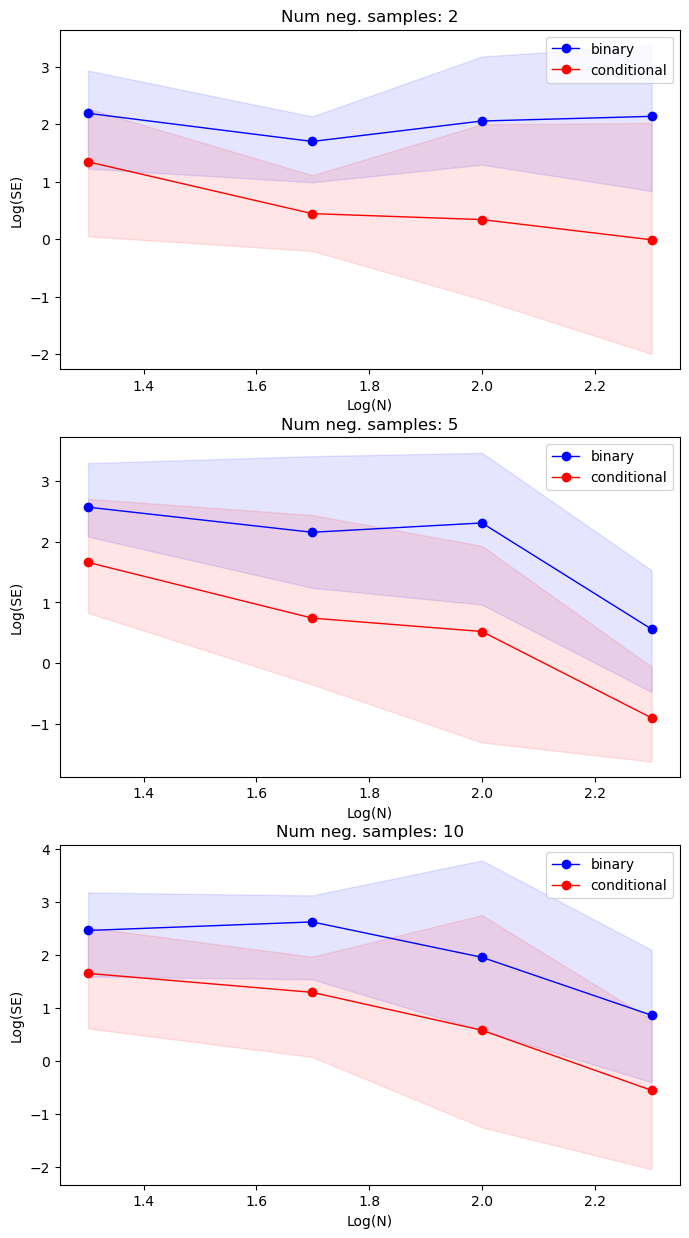

In [11]:
# Visualise results

error_res = np.load("res/final_param_error_ring_model_all.npy")

fig, ax = plt.subplots(len(num_neg_samples), 1, figsize=(8, 15))
colors = ['b', 'r']

log_num_samples = np.log10(np.array(num_samples))
for j, axis in enumerate(ax):
    for k, (crit, lab) in enumerate(zip(criteria, crit_labels)):
        plot_res(log_num_samples, np.log10(error_res[:, j, k, :]), lab, colors[k], axis)
        
    axis.set_title("Num neg. samples: {}".format(num_neg_samples[j]))    
    axis.set_xlabel("Log(N)")
    axis.set_ylabel("Log(SE)")
    axis.legend()
        
plt.show()